# Исследование зависимости протекания коронавируса и доли зараженных от континента

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

%matplotlib inline

In [2]:
df = pd.read_csv('owid-covid-data.csv')
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206610,ZWE,Africa,Zimbabwe,2022-08-01,256382.0,4.0,16.000,5577.0,0.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
206611,ZWE,Africa,Zimbabwe,2022-08-02,256403.0,21.0,17.000,5578.0,1.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
206612,ZWE,Africa,Zimbabwe,2022-08-03,256423.0,20.0,15.429,5579.0,1.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
206613,ZWE,Africa,Zimbabwe,2022-08-04,256444.0,21.0,15.429,5581.0,2.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206615 entries, 0 to 206614
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    206615 non-null  object 
 1   continent                                   194670 non-null  object 
 2   location                                    206615 non-null  object 
 3   date                                        206615 non-null  object 
 4   total_cases                                 198242 non-null  float64
 5   new_cases                                   198014 non-null  float64
 6   new_cases_smoothed                          196837 non-null  float64
 7   total_deaths                                179472 non-null  float64
 8   new_deaths                                  179450 non-null  float64
 9   new_deaths_smoothed                         178283 non-null  float64
 

Так как в данных много пропусков, и они разбросаны по таблице неоднородно, мы не будем удалять данные непосредственно в таблице, а будем рассматривать каждый случай отдельно, вынося его в новую таблицу, в которой уже будет производиться работа с пустыми значениями.

In [4]:
#переведем дату в соответствующий ей формат, чтобы было удобнее работать с данными
df['date'] = df['date'].astype("datetime64")

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Влияет ли континент на миллионную долю случаев ковида?

Рассмотрим, зависит ли миллионная доля случаев в стране от континента, на котором она расположена.

In [6]:
df_groups = df[['continent', 'total_cases_per_million', 'location']]
df_groups = df_groups.dropna(subset = ['total_cases_per_million', 'continent'])
df_groups = df_groups.groupby(by = ['location'], as_index = False).max()

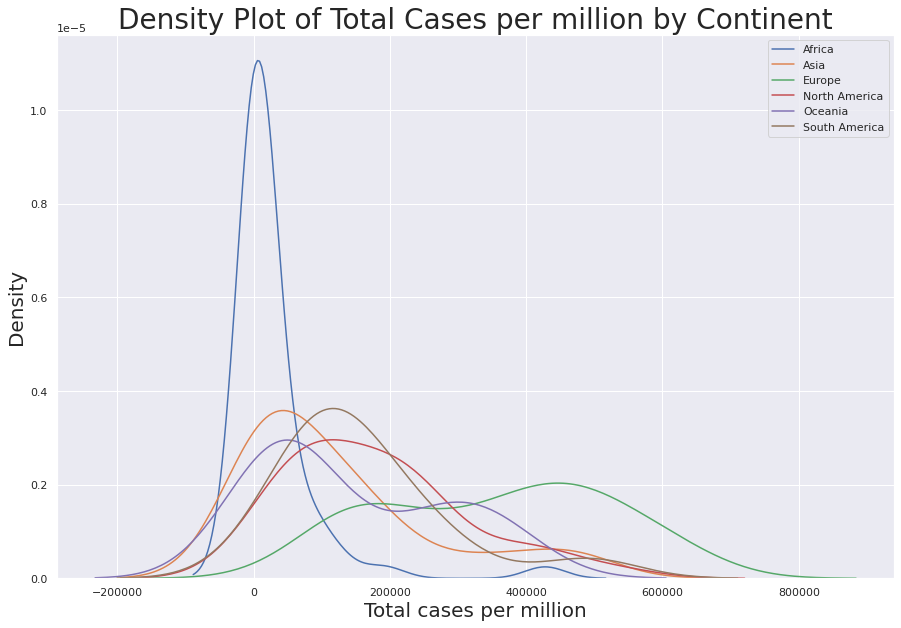

In [7]:
continents = df_groups['continent'].value_counts()
continents = list(continents.index)
plt.figure(figsize = (15, 10))
for name in continents:
    subset = df_groups[df_groups['continent'] == name]
    sns.kdeplot(subset['total_cases_per_million'].dropna(), label = name)
plt.xlabel('Total cases per million', size = 20);
plt.ylabel('Density', size = 20); 
plt.legend()
plt.title('Density Plot of Total Cases per million by Continent', size = 28);
plt.savefig('density_plot_1.png')

# Как ковид распространялся по континентам?

In [8]:
cut_eu = df[df['continent'] == 'Europe'].groupby(by = ['date']).agg({'new_cases_smoothed_per_million':'sum'})
cut_asia = df[df['continent'] == 'Asia'].groupby(by = ['date']).agg({'new_cases_smoothed_per_million':'sum'})
cut_na = df[df['continent'] == 'North America'].groupby(by = ['date']).agg({'new_cases_smoothed_per_million':'sum'})
cut_sa = df[df['continent'] == 'South America'].groupby(by = ['date']).agg({'new_cases_smoothed_per_million':'sum'})
cut_afr = df[df['continent'] == 'Africa'].groupby(by = ['date']).agg({'new_cases_smoothed_per_million':'sum'})
cut_oc = df[df['continent'] == 'Oceania'].groupby(by = ['date']).agg({'new_cases_smoothed_per_million':'sum'})

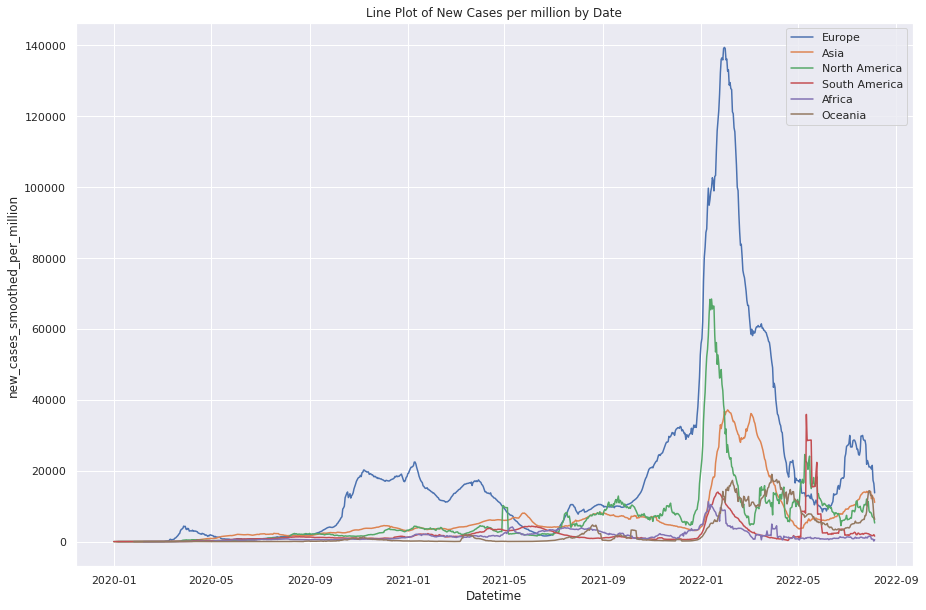

In [9]:
#cases
plt.figure(figsize = (15, 10))
g = sns.lineplot(data = cut_eu, x = 'date', y = 'new_cases_smoothed_per_million', label = 'Europe')
g = sns.lineplot(data = cut_asia, x = 'date', y = 'new_cases_smoothed_per_million', label = 'Asia')
g = sns.lineplot(data = cut_na, x = 'date', y = 'new_cases_smoothed_per_million', label = 'North America')
g = sns.lineplot(data = cut_sa, x = 'date', y = 'new_cases_smoothed_per_million', label = 'South America')
g = sns.lineplot(data = cut_afr, x = 'date', y = 'new_cases_smoothed_per_million', label = 'Africa')
g = sns.lineplot(data = cut_oc, x = 'date', y = 'new_cases_smoothed_per_million', label = 'Oceania')
plt.xlabel('Datetime')
plt.title('Line Plot of New Cases per million by Date')
plt.savefig('line_plot_cases_1.png')

In [10]:
vacc_eu = df[df['continent'] == 'Europe'].groupby(by = ['date']).agg({'new_vaccinations_smoothed_per_million':'sum'})
vacc_asia = df[df['continent'] == 'Asia'].groupby(by = ['date']).agg({'new_vaccinations_smoothed_per_million':'sum'})
vacc_na = df[df['continent'] == 'North America'].groupby(by = ['date']).agg({'new_vaccinations_smoothed_per_million':'sum'})
vacc_sa = df[df['continent'] == 'South America'].groupby(by = ['date']).agg({'new_vaccinations_smoothed_per_million':'sum'})
vacc_afr = df[df['continent'] == 'Africa'].groupby(by = ['date']).agg({'new_vaccinations_smoothed_per_million':'sum'})
vacc_oc = df[df['continent'] == 'Oceania'].groupby(by = ['date']).agg({'new_vaccinations_smoothed_per_million':'sum'})

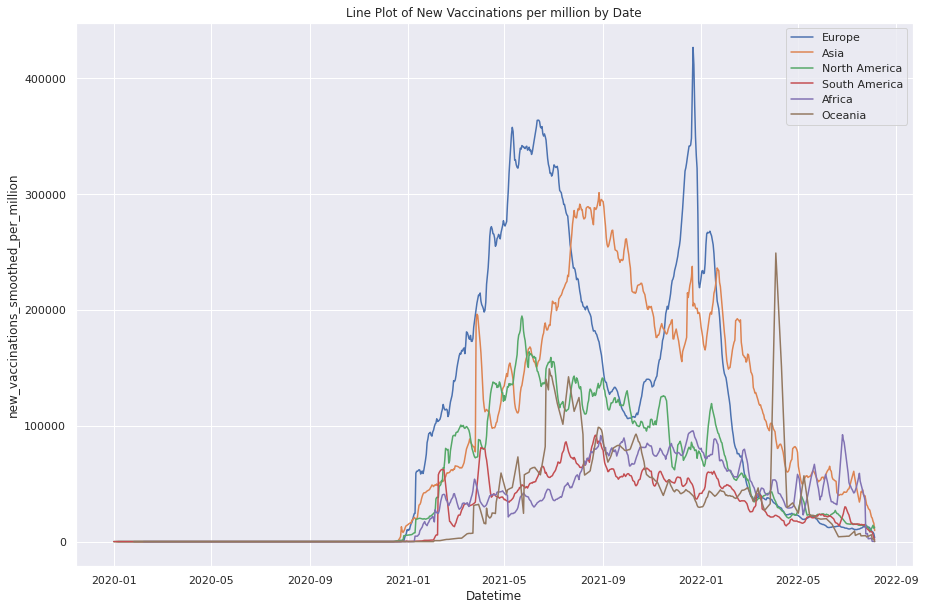

In [11]:
#vaccinations
plt.figure(figsize = (15, 10))
g = sns.lineplot(data = vacc_eu, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'Europe')
g = sns.lineplot(data = vacc_asia, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'Asia')
g = sns.lineplot(data = vacc_na, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'North America')
g = sns.lineplot(data = vacc_sa, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'South America')
g = sns.lineplot(data = vacc_afr, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'Africa')
g = sns.lineplot(data = vacc_oc, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'Oceania')
plt.xlabel('Datetime')
plt.title('Line Plot of New Vaccinations per million by Date')
plt.savefig('line_plot_vacc.png')

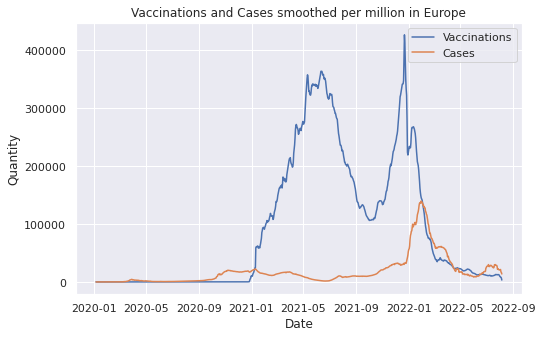

In [12]:
plt.figure(figsize = (8, 5))
g = sns.lineplot(data = vacc_eu, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'Vaccinations')
g = sns.lineplot(data = cut_eu, x = 'date', y = 'new_cases_smoothed_per_million', label = 'Cases')
plt.ylabel('Quantity')
plt.xlabel('Date')
plt.title('Vaccinations and Cases smoothed per million in Europe')
plt.savefig('vacc_cases_eu.png')

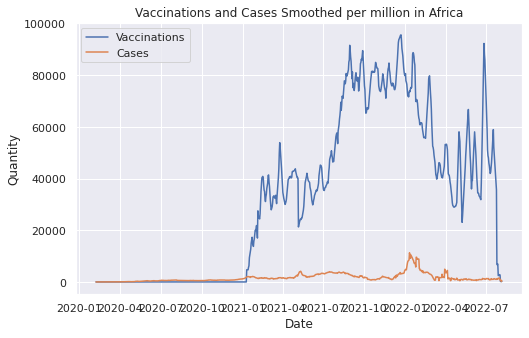

In [13]:
plt.figure(figsize = (8, 5))
g = sns.lineplot(data = vacc_afr, x = 'date', y = 'new_vaccinations_smoothed_per_million', label = 'Vaccinations')
g = sns.lineplot(data = cut_afr, x = 'date', y = 'new_cases_smoothed_per_million', label = 'Cases')
plt.ylabel('Quantity')
plt.xlabel('Date')
plt.title('Vaccinations and Cases Smoothed per million in Africa')
plt.savefig('cases_vacc_afr.png')

In [14]:
#распределение континентов по общим признакам
signes = df.groupby(by = ['continent']).agg({'female_smokers':'mean', 'stringency_index':'mean', 'male_smokers':'mean',
        'gdp_per_capita':'mean', 'life_expectancy':'mean', 'aged_65_older':'mean', 'population_density':'mean', 'human_development_index':'mean', 'cardiovasc_death_rate':'mean'})
signes.reset_index(inplace = True)
signes

,continent,female_smokers,stringency_index,male_smokers,gdp_per_capita,life_expectancy,aged_65_older,population_density,human_development_index,cardiovasc_death_rate
0,Africa,2.580233,46.902713,27.424612,5473.770061,64.390937,3.676645,102.958045,0.561373,287.331962
1,Asia,4.789639,53.916327,39.636087,24847.318026,74.768138,6.751875,1026.238795,0.741040,291.261898
2,Europe,23.395658,46.777662,35.529962,33444.760763,79.795111,17.739996,623.344765,0.880274,229.260947
3,North America,7.013087,52.632266,22.283977,21454.411084,76.764891,9.930003,254.071650,0.756913,196.476476
4,Oceania,16.882195,47.807894,33.812614,12469.656544,74.216040,7.952196,121.670978,0.723343,360.724278
5,South America,11.005896,59.377624,24.685936,13881.420036,75.584857,8.298578,24.390869,0.763857,187.087050


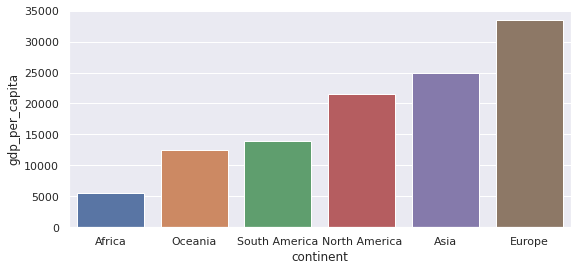

In [15]:
plt.figure(figsize = (9, 4))
sns.barplot(x = 'continent', y = 'gdp_per_capita', data = signes.sort_values(by = ['gdp_per_capita']))
plt.savefig('hist_gdp.png')

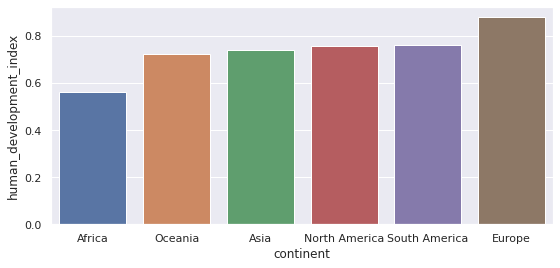

In [16]:
plt.figure(figsize = (9, 4))
sns.barplot(x = 'continent', y = 'human_development_index', data = signes.sort_values(by = ['human_development_index']))
plt.savefig('hist_hdi.png')

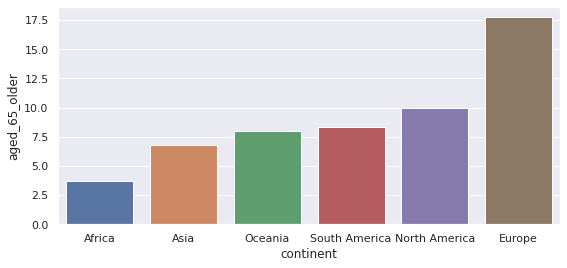

In [17]:
plt.figure(figsize = (9, 4))
sns.barplot(x = 'continent', y = 'aged_65_older', data = signes.sort_values(by = ['aged_65_older']))
plt.savefig('hist_65.png')

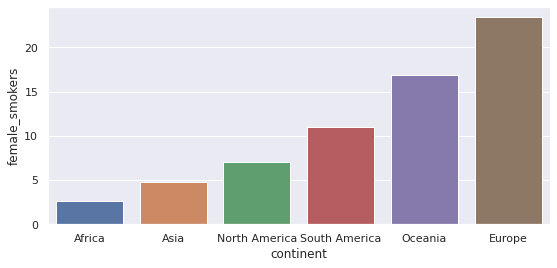

In [18]:
plt.figure(figsize = (9, 4))
sns.barplot(x = 'continent', y = 'female_smokers', data = signes.sort_values(by = ['female_smokers']))
plt.savefig('f_smokers.png')

## Для Африки

In [19]:
#зависимость total_cases_per_million ot vacc_per_hundred, tests_per_thousand и параметров стран
cases_afr = df[df['continent'] == 'Africa'].groupby(by = ['location']).agg({'total_vaccinations_per_hundred':'max', 'female_smokers':'mean', 'male_smokers':'mean', 'total_tests_per_thousand':'max', 
     'total_cases_per_million':'max','life_expectancy':'mean', 'median_age':'mean', 'aged_65_older': 'mean', 'gdp_per_capita':'mean'})
cases_afr.dropna(inplace = True)

In [20]:
X = cases_afr[['total_vaccinations_per_hundred','gdp_per_capita', 'female_smokers', 'aged_65_older', 'total_tests_per_thousand', 'life_expectancy', 'male_smokers']]
y = cases_afr['total_cases_per_million']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [23]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns = ['Coef'])
coefficients

,Coef
total_vaccinations_per_hundred,-86.390560
gdp_per_capita,0.545511
female_smokers,1495.713711
aged_65_older,6906.733884
total_tests_per_thousand,101.617440
life_expectancy,-518.888404
male_smokers,7.389090


In [24]:
y_pred = model.predict(X_test)
df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_pred

,Actual,Predicted
location,,
Ghana,5126.118,4177.479651
Namibia,66894.426,58480.728794
Senegal,5187.619,1380.663286
Mauritius,191482.891,146701.635243
Botswana,125838.783,104394.121410
Sierra Leone,918.814,13671.357958
South Africa,67425.542,69240.613818


In [25]:
mean_absolute_error(y_test, y_pred)

13423.26062754282

In [26]:
delta = cases_afr['total_cases_per_million'].max() - cases_afr['total_cases_per_million'].min()
print(mean_absolute_error(y_test, y_pred) / delta)

0.07023407043042791


In [27]:
r2_score(y_test, y_pred)

0.9122552828905188

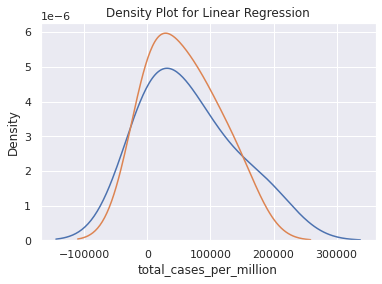

In [28]:
g = sns.kdeplot(y_test)
g = sns.kdeplot(y_pred)
plt.title('Density Plot for Linear Regression')
plt.savefig('lin_afr.png')

# Для Европы

In [29]:
cases_eu = df[df['continent'] == 'Europe'].groupby(by = ['location']).agg({'total_vaccinations_per_hundred':'max', 'female_smokers':'mean', 'total_tests_per_thousand':'max', 
     'total_cases_per_million':'max','life_expectancy':'mean', 'median_age':'mean', 'gdp_per_capita':'mean', 'stringency_index':'mean', 'extreme_poverty':'mean', 'hospital_beds_per_thousand':'mean', 'human_development_index':'mean'})
cases_eu.dropna(inplace = True)

In [30]:
X_eu = cases_eu[['total_vaccinations_per_hundred', 'female_smokers', 'life_expectancy', 'hospital_beds_per_thousand', 'stringency_index', 'extreme_poverty', 'median_age', 'total_tests_per_thousand', 'human_development_index']]
y_eu = cases_eu['total_cases_per_million']
X_train_eu, X_test_eu, y_train_eu, y_test_eu = train_test_split(X_eu, y_eu, test_size = 0.2, random_state = 0)

In [31]:
model_eu = LinearRegression()
model_eu.fit(X_train_eu, y_train_eu)

LinearRegression()

In [32]:
coeff_eu = pd.DataFrame(model_eu.coef_, X_eu.columns, columns = ['Coef'])
coeff_eu

,Coef
total_vaccinations_per_hundred,638.972809
female_smokers,-3485.376072
life_expectancy,-15821.429643
hospital_beds_per_thousand,-16333.090258
stringency_index,-5651.665190
extreme_poverty,-2784.601725
median_age,15897.980626
total_tests_per_thousand,19.842317
human_development_index,778431.065546


In [33]:
y_pred_eu = model_eu.predict(X_test_eu)
df_pred_eu = pd.DataFrame({'Actual': y_test_eu, 'Predicted': y_pred_eu})
df_pred_eu

,Actual,Predicted
location,,
Belgium,382149.556,316971.732479
Russia,126810.776,227440.201793
Lithuania,427097.616,394569.538904
Norway,269636.376,347171.774020
Croatia,293661.418,246509.449296
Ireland,330411.393,292888.887327


In [34]:
r2_score(y_test_eu, y_pred_eu)

0.5410458919283929

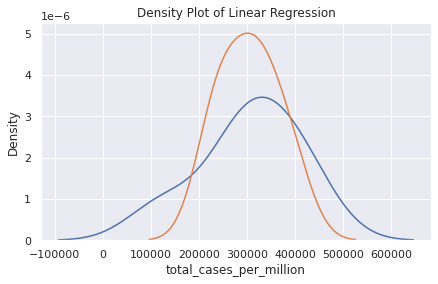

In [35]:
plt.figure(figsize = (7, 4))
g = sns.kdeplot(y_test_eu)
g = sns.kdeplot(y_pred_eu)
plt.title('Density Plot of Linear Regression')
plt.savefig('lin_eu.png')

# Определение континента по параметрам протекания ковида

In [36]:
cases = df.groupby(by = ['location']).agg({'total_vaccinations_per_hundred':'max', 'female_smokers':'mean', 'male_smokers':'mean', 'total_tests_per_thousand':'max', 
     'total_cases_per_million':'max','life_expectancy':'mean', 'median_age':'mean', 'aged_65_older': 'mean', 'gdp_per_capita':'mean', 'continent':'max', 'extreme_poverty':'mean',
                                           'human_development_index':'mean', 'total_deaths_per_million':'max', 'population_density':'mean', 'diabetes_prevalence':'mean'})
cases.dropna(inplace = True)
cases.shape

(95, 15)

N = 95, значит, возьвем k такое, что k^2 = N: k = 10

In [37]:
X_c = cases[['total_vaccinations_per_hundred','gdp_per_capita', 'female_smokers', 'aged_65_older', 'median_age', 'total_tests_per_thousand', 'life_expectancy', 'male_smokers', 'total_cases_per_million',
            'human_development_index', 'extreme_poverty', 'total_deaths_per_million', 'population_density', 'diabetes_prevalence']]
y_c = cases['continent']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size = 0.2, random_state = 0)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
model_c = KNeighborsClassifier(n_neighbors=10)
model_c.fit(X_train_c, y_train_c)

KNeighborsClassifier(n_neighbors=10)

In [39]:
y_pred_c = model_c.predict(X_test_c)
y_pred_c

/home/whiteinc/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array(['Europe', 'Africa', 'Europe', 'Europe', 'Asia', 'Asia', 'Africa',
       'Africa', 'Europe', 'Africa', 'Europe', 'Europe', 'Africa', 'Asia',
       'Africa', 'Africa', 'Africa', 'Africa', 'Europe'], dtype=object)

In [40]:
print(f'accuracy: {accuracy_score(y_test_c, y_pred_c)}')

accuracy: 0.6842105263157895


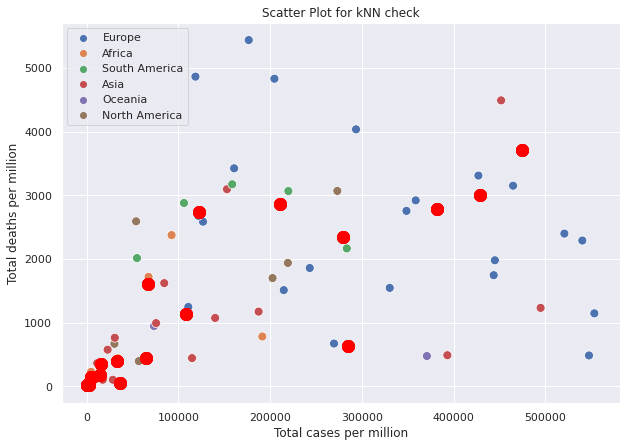

In [41]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='total_cases_per_million', y='total_deaths_per_million', data=cases, hue ='continent', s = 80)
plt.xlabel('Total cases per million')
plt.ylabel('Total deaths per million')
plt.legend()
plt.title('Scatter Plot for kNN check')
for i in range(len(y_test_c)):
    if np.array(y_test_c)[i] != y_pred_c[i]:
        plt.scatter(X_test_c['total_cases_per_million'], X_test_c['total_deaths_per_million'], color='red', s = 140)
plt.savefig('knn_plot.png')